In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skvideo.io
import csv
import os
from tqdm import tqdm
import cv2 as cv
from scipy.optimize import minimize
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

In [ ]:
# flow_mat = None
# image_scale = 0.5
# pyr_images = 1 # was 3
# win_size = 15
# pyr_iterations = 2 # was 3
# poly_expans = 5
# std = 1.3 # was 1.2

flow_mat = None
image_scale = 0.5
pyr_images = 1 # was 3
win_size = 10
pyr_iterations = 2 # was 3
poly_expans = 5
std = 1.3 # was 1.2

In [ ]:
cap = cv.VideoCapture(cv.samples.findFile("../train/videos/trash/trainGray_Clipped.m4v"))
# cap = cv.VideoCapture(cv.samples.findFile("../train/videos/trainGray.mp4"))
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
# prvs = frame1
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    if ret == True:
        next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
#         next = frame2
        flow = cv.calcOpticalFlowFarneback(prvs,next, flow_mat, image_scale, pyr_images, win_size, pyr_iterations, poly_expans, std, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
        bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
        cv.imshow('frame2',bgr)
        k = cv.waitKey(50) & 0xff
        if k == 27:
            break
        prvs = next
    else:
        break
cap.release()
cv.destroyAllWindows()

In [ ]:
grad = ((np.dot(z, alpLmbTheta[idx, idx2]) - trainY[j])*z)/m
grad[1:len(grad)] = grad[1:len(grad)] + ((lmbd/m)*alpLmbTheta[idx,idx2,1:len(alpLmbTheta[idx,idx2])])

In [ ]:
for i in range(100):
    rand_num = np.random.uniform()
    bright_factor = 0.2 + rand_num
    print(rand_num, bright_factor)

In [ ]:
a = np.arange(18).reshape(9,2)
# b = a.reshape(3,3,2).swapaxes(0,2)
b = a.reshape(2,3,3)
print(a.shape)
print(a)
print()
print(b.shape)
print(b)
print()
b.shape = (9,2)
print(b.shape)
print(b)

In [2]:
def adjust_Value(prvs_FRAME, curr_FRAME, HSV_value):
    prvs_FRAME = cv.cvtColor(prvs_FRAME, cv.COLOR_BGR2HSV)
    curr_FRAME = cv.cvtColor(curr_FRAME, cv.COLOR_BGR2HSV)
    prvs_FRAME[...,2] = prvs_FRAME[...,2]*HSV_value
    curr_FRAME[...,2] = curr_FRAME[...,2]*HSV_value
    return prvs_FRAME, curr_FRAME

In [3]:
def opticalFlow_DENSE(prvs_FRAME, curr_FRAME):
    # flow_mat = None
    # image_scale = 0.5
    # pyr_images = 1 # was 3
    # win_size = 15
    # pyr_iterations = 2 # was 3
    # poly_expans = 5
    # std = 1.3 # was 1.2
    
    flow_mat = None
    image_scale = 0.5
    pyr_images = 1 # was 3
    win_size = 10
    pyr_iterations = 2 # was 3
    poly_expans = 5
    std = 1.3 # was 1.2

    hsv = np.zeros_like(prvs_FRAME)
    hsv[...,1] = 255
    prvs_FRAME = cv.cvtColor(prvs_FRAME,cv.COLOR_BGR2GRAY)
    curr_FRAME = cv.cvtColor(curr_FRAME,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs_FRAME,curr_FRAME,flow_mat,image_scale,pyr_images,win_size,pyr_iterations,poly_expans,std,0)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    return bgr

In [4]:
def getData(train_meta, kLoopCount, learn_index):
    #print('In getData')
    global img_pix_count
    opt_flows = np.empty((0,img_pix_count), dtype='uint8')
    speed = np.empty((0))
    for k in range(kLoopCount):
        HSV_value = np.random.uniform(low=.7, high=1.4)
        curr_FRAME = cv.imread(train_meta['image_path'][learn_index[k]])
        prvs_FRAME = cv.imread(train_meta['image_path'][learn_index[k]-1])
        speed = np.append(speed, train_meta['speed'][learn_index[k]])
        prvs_FRAME, curr_FRAME = adjust_Value(prvs_FRAME, curr_FRAME, HSV_value)
        opt_flow = opticalFlow_DENSE(prvs_FRAME, curr_FRAME)
        opt_flow.shape = img_pix_count
        opt_flow.dtype = 'uint8'
        opt_flows = np.append(opt_flows, [opt_flow], axis=0)
    #print('Opt FLOWS Shape:', opt_flows.shape, 'Type:', opt_flows.dtype)
    #print('Speed Shape:', speed.shape, 'Type:', speed.dtype)
    #print('Out getData')
    #print()
    return opt_flows, speed

In [5]:
def linearCost(th, X, y, m):
    if X.shape[0] % img_pix_count == 0:
        print('X Type:', X.dtype, 'X Shape:', X.shape)
        data_set_length = int(X.shape[0]/img_pix_count)
        print('Data Set Length:', data_set_length, 'Data Set Type:', type(data_set_length))
        X = X.reshape(data_set_length, img_pix_count)
    J = np.sum((np.dot(X, th) - y)**2)/m
    #print()
    return J
    
def linearDer(th, X, y, m):
    if X.shape[0] % img_pix_count == 0:
        #print('X Type:', X.dtype, 'X Shape:', X.shape)
        data_set_length = int(X.shape[0]/img_pix_count)
        #print('Data Set Length:', data_set_length, 'Data Set Type:', type(data_set_length))
        X = X.reshape(data_set_length, img_pix_count)
        #print('X Type:', X.dtype, 'X Shape:', X.shape)
        #print('Theta Type:', theta.dtype, 'Theta Shape:', theta.shape)
    grad = np.sum((np.dot(X, th) - y)*np.transpose(X), axis=1)/m
    #print(grad.shape)
    grad[1:len(grad)] = grad[1:len(grad)] + ((lmbd/m)*th[1:len(th)])
    #print('Gradient Shape:', grad.shape, 'Gradient Type:', grad.dtype)
    #print()
    return grad

In [6]:
def learn(X, y, m, loopCount):
    #print('In learn')
    global theta
    theta = (theta - (alpha*linearDer(theta, X,y,m)))
    #res = minimize(linearCost, theta, args=(X,y,m), method='BFGS', jac=linearDer, options={'gtol': 1e-6, 'disp': True, 'maxIter': loopCount})
    #print('X Shape:', X.shape, 'Y Shape:', y.shape)
    #res = minimize(linearCost, X, args=(y,m), method='BFGS', jac=linearDer, options={'disp': True, 'maxiter': loopCount})
    #print('Out learn')
    #print()

In [7]:
def getCost(train_meta, learn_index, train_length, jLoopCount, kLoopCount):
    #print('In getCost')
    global COST
    cost = 0
    index = 0
    tqdm.write('Cost Loop')
    for j in tqdm(range(jLoopCount)):
        kLoopCount = kLoopCount if (index+kLoopCount)<=train_length else (train_length-index)
        X, y = getData(train_meta, kLoopCount, learn_index[index:index+kLoopCount])
        #print('X Shape:', X.shape, 'Y Shape:', y.shape)
        #print('X Type:', X.dtype, 'Y Type:', y.dtype)
        index = index+kLoopCount
        cost = cost + linearCost(theta, X, y, 1)
        #print('cost:',cost)
    #cost = cost/learn_index.shape[0]
    cost = cost/(jLoopCount*kLoopCount)
    COST = np.append(COST, cost)
    print('COST:', cost, 'COST Type:', type(cost))
    #print('Out getCost')
    #print()

In [8]:
def startLearn(train_csv_path, iLoopCount, kLoopCount, learnLoopCount, costOnLoop, m):
    #print('In startLearn')
    train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))
    
    train_frames = train_meta.shape[0]
    train_length = int(.8*train_frames-1)
    #print('Train Length:', train_length)
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    learn_index = data_index[0:train_length]
    #print('Learn Index:', learn_index.shape)
    
    #iLoopCount = 1
    #kLoopCount = 1
    jLoopCount = int(train_length/kLoopCount) if train_length%kLoopCount==0 else (int(train_length/kLoopCount)+1)
    #learnLoopCount = 10
    #m = kLoopCount
    
    #getCost(train_meta, learn_index, train_length, jLoopCount, kLoopCount)
    for i in range(iLoopCount):
        index = 0
        tqdm.write(f'Iteration: {i}')
        for j in tqdm(range(jLoopCount)):
            #print('IDX|JDX:', i, j)
            kLoopCount = kLoopCount if (index+kLoopCount)<=train_length else (train_length-index)
            opt_flow, speed = getData(train_meta, kLoopCount, learn_index[index:index+kLoopCount])
            index = index + kLoopCount
            learn(opt_flow, speed, m, learnLoopCount)
        if i % costOnLoop == 0:
            getCost(train_meta, learn_index, train_length, jLoopCount, kLoopCount)
    #print('Out startLearn')
    #print()

In [9]:
def startValCheck(train_csv_path, kLoopCount, learnLoopCount, m):
    #print('In startLearn')
    train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))
    
    train_frames = train_meta.shape[0]
    train_length = int(.8*train_frames-1)
    val_length = int(.2*train_frames-1)
    #print('Train Length:', train_length)
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    val_index = data_index[train_length:]
    #print('Val Index:', learn_index.shape)
    
    #iLoopCount = 1
    #kLoopCount = 1
    jLoopCount = int(val_length/kLoopCount) if val_length%kLoopCount==0 else (int(val_length/kLoopCount)+1)
    #learnLoopCount = 10
    #m = kLoopCount
    
    getCost(train_meta, val_index, val_length, jLoopCount, kLoopCount)

In [10]:
def plotCost():
    index = np.empty((0),np.dtype('int'))
    for i in range(len(COST)):
        index = np.append(index,i)
    plt.plot(index[1:],COST[1:])

In [ ]:
def getResult():
    train_meta = pd.read_csv(os.path.join(train_csv_path, 'trainGrayClipped_meta.csv'))
    
    train_frames = train_meta.shape[0]
    train_length = int(.8*train_frames-1)
    val_length = int(.2*train_frames-1)
    
    data_index = np.loadtxt('../train/text/train_val_index.txt', np.dtype('int16'), delimiter='\n')
    learn_index = data_index[0:train_length]
    val_index = data_index[train_length:]
    
    train_result = np.empty((0,2), dtype='float32')
    val_result = np.empty((0,2), dtype='float32')
    
    for i in range(train_length):
        opt_flow, speed = getData(train_meta, 1, learn_index[i])
        train_speed = opt_flow*theta
        train_result = np.append(train_result, [[train_speed, speed]])
    
    for i in range(val_length):
        opt_flow, speed = getData(train_meta, 1, val_index[i])
        val_speed = opt_flow*theta
        val_result = np.append(val_result, [[val_speed, speed]])

In [11]:
def start(iLoopCount, kLoopCount, learnLoopCount, costOnLoop, alpha_arg, lmbd_arg):
    train_csv_path = '../train/text/CSV'
    m = kLoopCount
    alpha = alpha_arg
    lmbd = lmbd_arg
    startLearn(train_csv_path, iLoopCount, kLoopCount, learnLoopCount, costOnLoop, m)
    plotCost()
    startValCheck(train_csv_path, kLoopCount, learnLoopCount, m)

In [12]:
# Global Vars
img_pix_count = (cv.imread('../train/photos/images/gray_Clipped/0.jpg')).shape
img_pix_count = (img_pix_count[0] * img_pix_count[1])*3
print('Pixel Count:', img_pix_count)

theta = np.zeros(img_pix_count, dtype='float32')
#theta = np.loadtxt('../train/text/theta/train_theta_gray_Clipped.txt', np.dtype('float64'), delimiter='\n')
print('Theta Shape:', theta.shape)
COST = np.empty((0))
lmbd = 0.1
#alpha = 0.000000001
alpha = 0.0000001

Pixel Count: 130560
Theta Shape: (130560,)


  0%|          | 0/9 [00:00<?, ?it/s]

Iteration: 0


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 49.54370791403777 COST Type: <class 'numpy.float64'>
Iteration: 1


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 47.252825801344166 COST Type: <class 'numpy.float64'>
Iteration: 2


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 49.10509257014456 COST Type: <class 'numpy.float64'>
Iteration: 3


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 50.002428698521555 COST Type: <class 'numpy.float64'>
Iteration: 4


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 47.83838367566041 COST Type: <class 'numpy.float64'>
Iteration: 5


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 47.87026350686745 COST Type: <class 'numpy.float64'>
Iteration: 6


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 47.35649011062739 COST Type: <class 'numpy.float64'>
Iteration: 7


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 47.629660375514476 COST Type: <class 'numpy.float64'>
Iteration: 8


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/9 [00:00<?, ?it/s]

COST: 46.995744049070346 COST Type: <class 'numpy.float64'>
Iteration: 9


  0%|          | 0/9 [00:00<?, ?it/s]

Cost Loop


  0%|          | 0/3 [00:00<?, ?it/s]

COST: 46.66676237704955 COST Type: <class 'numpy.float64'>
Cost Loop


100%|██████████| 3/3 [01:58<00:00, 39.56s/it]

COST: 844.0746629418156 COST Type: <class 'numpy.float64'>


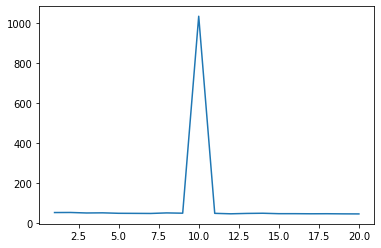

In [14]:
start(20, 2000, 1, 1, 0.000000001, 0.05)

In [ ]:
plotCost()

In [ ]:
for i in range(1,len(COST)-2, 2):
    a = COST[i]-COST[i+2]
    print(a)

In [ ]:
startLearn(train_csv_path)
startValCheck(train_csv_path)

In [ ]:
startValCheck(train_csv_path)

In [ ]:
alpha = 0.01          # Doesn't work
alpha = 0.001         # Doesn't work
alpha = 0.0001        # Doesn't work
alpha = 0.00001       # Doesn't work
alpha = 0.000001      # Doesn't work
alpha = 0.0000001     # Doesn't work
alpha = 0.00000001    # Doesn't work
alpha = 0.000000001   # Does work
alpha = 0.0000000001  # Does work
alpha = 0.00000000001 # Does work
alpha = 0.00000000005 # Does work slow
alpha = 0.000000000001# Does work I think
                      #  

In [ ]:
alpha = 0.00000001

idx = 1
Train Cost = 70.939
Val Cost = 64

idx = 10
Train Cost = 48
Val Cost =

alpha = 0.000000001

idx = 10
Train Cost = 32 - 51 # 23.381966590088346 new  24.623130857418463 - 49.147585482569085 right now
Val Cost =

alpha = 0.0000000001

idx = 10
Train Cost = 41 - 58 - 35 - 57
Val Cost =

alpha = 0.00000000005

idx = 10
Train Cost = 46 - 51 - 38 - 58
Val Cost =

alpha = 0.00000000001

idx = 10
Train Cost = 
Val Cost =

alpha = 0.000000000001

idx = 10
Train Cost = 173 - 135 - 130 - 103 - 111 - 89 - 103
Val Cost =

In [ ]:
theta.tofile('../train/text/theta/train_theta_gray_Clipped.txt',sep="\n",format="%s")

In [ ]:
36